# Error-space diagram - example for 1 input pair, 1 derived var, 1 region

#### Load needed packages

In [1]:
import rpy2

# necessary to workaround the error: /u01/anaconda2/lib/libreadline.so.6: undefined symbol: PC
# https://www.rittmanmead.com/blog/2016/07/using-r-jupyter-notebooks-big-data-discovery/
import readline

%load_ext rpy2.ipython

In [2]:
%%R
#libraries previously installed using:
library(seacarb)
library(oce)
library(gsw)

#library(Hmisc)   #for minor ticks in plot

packageVersion('seacarb')

/homel/cnangini/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Le chargement a nécessité le package : oce

  warnings.warn(x, RRuntimeWarning)
/homel/cnangini/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Le chargement a nécessité le package : gsw

  warnings.warn(x, RRuntimeWarning)


[1] ‘3.1.1’


## 1. Get routines and specify input vars

### 1.1 Read in new and modified functions 

The commands below read in routines that have been modified (derivnum and errors) or are completely new relative to the standard version of the seacarb distribution.  You can get these new and modified routines from github:

git clone https://github.com/jamesorr/seacarb-git.git

Then just change the directory in the 4 lines of the cell just below:

In [3]:
%%R
#branch buffesm1 of seacarb-git
source("/homel/cnangini/PROJECTS/seacarb-git/R/errhalf.R")
source("/homel/cnangini/PROJECTS/seacarb-git/R/errmid.R")
source("/homel/cnangini/PROJECTS/seacarb-git/R/errors.R")
source("/homel/cnangini/PROJECTS/seacarb-git/R/derivnum.R")

### 1.2 Specify input variables and their corresponding uncertainties (errors)

In [34]:
%%R
#User inputs

# Specify flag
#   menu_flag = 15  #var1=ALK, var2=DIC
  menu_flag = 8   #var1=pH, var2=ALK


In [169]:
%%R

  temp = -0.49    #C
  salt = 33.96    #psu
  press = 0       #bar
  Phos = 2.e-6    #(umol/kg)
  Sil = 60.e-6    #(umol/kg)

  salt_e = 0.01   
  temp_e = 0.01   

  Pt_e = 0.1e-6
  Sit_e = 4.0e-6

#for testing purposes
ALK_socn = 2295e-6
DIC_socn = 2155e-6


pCO2_e <- seq(0,20,1)
pH_e   <- seq(0,0.03,0.0015)
ALK_e <- seq(0., 20., 1.0) * 1e-6



  if (menu_flag == 15){#var1=ALK, var2=DIC
      
      # Input variables:
      var1 = 2295e-6  #(umol/kg)
      var2 = 2155e-6
      
      # Uncertainties in input variables      
      var1_e <- seq(0., 20., 1.0) * 1e-6
      var2_e <- var1_e
      
      var1_e_soa   <- 2 #umol/kg
      var2_e_soa   <- 2 #umol/kg

      var1_e_soa2  <- c(var1_e_soa, var1_e_soa)
      var2_e_soa2  <- c(var2_e_soa, var2_e_soa)

      # for plot
      x <- var2_e*1e+6  ;  y <- var1_e*1e+6      
      xlim <- c(0,20)  ; ylim <- xlim
      levels1 <- c(1,seq(2,20,by=2))
      xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
      ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
      
  } else if (menu_flag == 8) {#var1=pH, var2=ALK
      # Input variables:
      var1 = 8.111823
      var2 = 2295e-6  #(umol/kg)
      
      # Uncertainties in input variables      
      var1_e <- seq(0,0.03,0.0015)
      var2_e <- seq(0., 20., 1.0) * 1e-6
      
      var1_e_soa   <- c(0.003, 0.01) #pH_e_soa    <- c(0.003, 0.01)
      var2_e_soa   <- 2 #umol/kg
      
      var1_e_soa2  <- var1_e_soa #pH_e_soa2   <- pH_e_soa
      var2_e_soa2  <- c(var2_e_soa, var2_e_soa) #ALK_e_soa2  <- c(ALK_e_soa, ALK_e_soa)
      
      # for plot
#       x <- var1_e           ;  y <- var2_e * 1e+6
      x <- pH_e           ;  y <- ALK_e * 1e+6
      xlim <- c(0,0.03) ; ylim <- c(0,20) 
      levels1 <- c(4.2, seq(4,7,by=1))
      xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
      ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
  }
 


# ALK_e_soa   <- 2 #umol/kg
# DIC_e_soa   <- 2 #umol/kg
# pCO2_e_soa  <- 2 #umol/kg
# pH_e_soa    <- c(0.003, 0.01)  #total scale

# pH_e_soa2   <- pH_e_soa
# ALK_e_soa2  <- c(ALK_e_soa, ALK_e_soa)
# DIC_e_soa2  <- c(DIC_e_soa, DIC_e_soa)
# pCO2_e_soa2 <- c(pCO2_e_soa, pCO2_e_soa)

In [107]:
%%R
var1_e_soa2

[1] 0.003 0.010


In [108]:
%%R
var2_e_soa2

[1] 2 2


### 1.3 Default uncertainties in equilibrium constants (pK0, pK1, pK2, pKb, pKw, pKa, pKc, Bt)

In [109]:
%%R
# Estimates for errors in constants in errors.R routine (from Orr et al., 2017)
  epKstd  <- c(0.004, 0.015,  0.03, 0.01,  0.01, 0.02, 0.02, 0.01)
# epKstd  <- c(0.004, 0.015,  0.03, 0.01,  0.01, 0.02, 0.02)

### 1.3 Compute derived carbonate system vars with std seacarb routine `carb`:

In [110]:
%%R
# Compute derived carbonate system variables with standard seacarb routine 'carb':

# Southern Ocean
vars <- carb  (flag=menu_flag, var1=var1, var2=var2, S=salt, T=temp, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                    k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

# vars <- carb  (flag=15, var1=ALK_socn, var2=DIC_socn, S=salt, T=temp, Patm=1, P=press, Pt=Phos, Sit=Sil, 
#                     k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')


pH <- vars$pH
pCO2 <- vars$pCO2

# Compute H+ from pH, i.e., pH = -log10[H+], where [H+] is the hydrogen ion concentration in mol/kg
H = 10^(-1*vars$pH)

# Keep only key columns to be consistent with output from 'errors.R' routine (called below)
vars <- data.frame(H, vars[,c('pH','CO2','fCO2','pCO2','HCO3','CO3','OmegaAragonite','OmegaCalcite')] )
vars

# Duplicate rows in *vars* until same as number of members of error vector ALK_e
numerrs <- length(var1_e)
vars <- vars[rep(row.names(vars), numerrs), ]


In [111]:
%%R
pH

[1] 8.111823


### 1.4 Use 1-D error vectors to build 2-D error array (to plot contours in DIC-ALK space)  

In [112]:
%%R
var2_e

 [1] 0.0e+00 1.0e-06 2.0e-06 3.0e-06 4.0e-06 5.0e-06 6.0e-06 7.0e-06 8.0e-06
[10] 9.0e-06 1.0e-05 1.1e-05 1.2e-05 1.3e-05 1.4e-05 1.5e-05 1.6e-05 1.7e-05
[19] 1.8e-05 1.9e-05 2.0e-05


In [113]:
%%R
#dat <- expand.grid(var2_e, var1_e) ####ALK & DIC
# dat <- expand.grid(var1_e, var2_e)

dat   <- expand.grid(pH_e,  ALK_e)
# dat_pHCt   <- expand.grid(pH_e,  DIC_e)
# dat_AtCt   <- expand.grid(DIC_e, ALK_e)

In [114]:
%%R
dat

      Var1    Var2
1   0.0000 0.0e+00
2   0.0015 0.0e+00
3   0.0030 0.0e+00
4   0.0045 0.0e+00
5   0.0060 0.0e+00
6   0.0075 0.0e+00
7   0.0090 0.0e+00
8   0.0105 0.0e+00
9   0.0120 0.0e+00
10  0.0135 0.0e+00
11  0.0150 0.0e+00
12  0.0165 0.0e+00
13  0.0180 0.0e+00
14  0.0195 0.0e+00
15  0.0210 0.0e+00
16  0.0225 0.0e+00
17  0.0240 0.0e+00
18  0.0255 0.0e+00
19  0.0270 0.0e+00
20  0.0285 0.0e+00
21  0.0300 0.0e+00
22  0.0000 1.0e-06
23  0.0015 1.0e-06
24  0.0030 1.0e-06
25  0.0045 1.0e-06
26  0.0060 1.0e-06
27  0.0075 1.0e-06
28  0.0090 1.0e-06
29  0.0105 1.0e-06
30  0.0120 1.0e-06
31  0.0135 1.0e-06
32  0.0150 1.0e-06
33  0.0165 1.0e-06
34  0.0180 1.0e-06
35  0.0195 1.0e-06
36  0.0210 1.0e-06
37  0.0225 1.0e-06
38  0.0240 1.0e-06
39  0.0255 1.0e-06
40  0.0270 1.0e-06
41  0.0285 1.0e-06
42  0.0300 1.0e-06
43  0.0000 2.0e-06
44  0.0015 2.0e-06
45  0.0030 2.0e-06
46  0.0045 2.0e-06
47  0.0060 2.0e-06
48  0.0075 2.0e-06
49  0.0090 2.0e-06
50  0.0105 2.0e-06
51  0.0120 2.0e-06
52  0.0135 2

### 1.5 Specify state-of-art (soa) errors for vars: from error-propagation manuscript (Orr et al. 2017, Table 1) 

These will be plotted as crosses on the error-space diagrams

## 2. Compute derived variables (with `carb`) and propagated errors (with `errors`)

### 2.1 Computations of derived vars and their errors (for At-Ct pair only) 

In [115]:
%%R
var2

[1] 0.002295


In [116]:
%%R
# Compute variables
vars <- carb  (flag=menu_flag, var1=var1, var2=var2, S=salt, T=temp, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                    k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

H = 10^(-1*vars$pH)         # H+ concentration (mol/kg)
vars <- data.frame(H, vars) # Add H+ as new column to vars data frame
vars_step2 <- vars



# Absolute errors: propagated uncertainties
if (menu_flag == 15) {
    absEt <- errors (flag=menu_flag, var1=var1, var2=var2, S=salt, T=temp, 
                      Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      evar1=dat$Var2, evar2=dat$Var1, eS=0, eT=0, ePt=0, eSit=0, epK=epKstd, #HUOM!!!                
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='no')
    
} else if (menu_flag == 8) { ##NB: SWAP dat$Var2 and dat$Var1 !!!!!!
    absEt <- errors (flag=menu_flag, var1=var1, var2=var2, S=salt, T=temp, 
                      Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      evar1=dat$Var1, evar2=dat$Var2, eS=0, eT=0, ePt=0, eSit=0, epK=epKstd, #HUOM!!!
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='no')
}


# Keep only key columns in vars for consistency with columns in absEt
vars <- vars[,colnames(absEt)] 
vars

# Duplicate rows in *vars* until same as number of members of error vector ALK_e
numerrs <- length(dat$Var1)
vars <- vars[rep(row.names(vars), numerrs), ]

#Relative errors (in percent)
relEt <- 100* absEt / vars            #Total relative error (from constants and other input variables)
# relEt

### 2.2 Define simpler names of variables to be plotted

In [117]:
%%R
#   Absolute changes (fCO2 missing):
    pH       <- absEt$pH
    pCO2     <- absEt$pCO2
    CO3      <- absEt$CO3
    CO2      <- absEt$CO2
    pCO2socn <- absEt$pCO2
    OmegaA   <- absEt$OmegaAragonite
    HCO3     <- absEt$HCO3
    H        <- absEt$H

#   Relative changes:
    rCO3  <- relEt$CO3
    rH    <- relEt$H
    rpCO2 <- relEt$pCO2
    rCO2  <- relEt$CO2
    #rpCO2   <- relEt$pCO2 ###DUPLICATE
    rOmegaA <- relEt$OmegaAragonite
    rHCO3   <- relEt$HCO3
    H       <- absEt$H

    rHCO3H <- sqrt(rHCO3^2 + rH^2)


## 3. Compute other parts of error-space diagrams

### 3.1 Constants-pair CURVE (along which propagated error from constants equals that from the input pair)

In [134]:
%%R
epKstd

[1] 0.004 0.015 0.030 0.010 0.010 0.020 0.020 0.010


In [199]:
%%R
# Critical curves (Constants-Pairs curve)
# ===============
# Southern Ocean
errcirc <- errhalf(flag=menu_flag, var1=var1, var2=var2, S=salt, T=temp, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")

if (menu_flag == 15) {
    sig1_AtCt   <- data.frame(errcirc[1]) * 1e+6
    sig2_AtCt   <- data.frame(errcirc[2]) * 1e+6
    # sigy_AtCt   <- data.frame(errcirc[3]) ###HUOM not used
    sig1hp_AtCt <- data.frame(errcirc[4]) * 1e+6
    sig2hp_AtCt <- data.frame(errcirc[5]) * 1e+6
} else if (menu_flag == 8) {
    sig1_AtCt   <- data.frame(errcirc[1]) #this is a pH
    sig2_AtCt   <- data.frame(errcirc[2]) * 1e+6    
    sig1hp_AtCt <- data.frame(errcirc[4]) #this is a pH
    sig2hp_AtCt <- data.frame(errcirc[5]) * 1e+6
    
}


### 3.2 Balanced-pair LINE (along which both members of input pair contrbute equally to propagated error)

In [200]:
%%R
sigyspct <- seq(0,20,by=0.1) # in percent

# At-Ct pair
# ----------
# Southern Ocean
errm <- errmid(flag=menu_flag, var1=var1, var2=var2, S=salt, T=temp, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   sigyspct, epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")

if (menu_flag == 15) {
    sigm1_AtCt   <- data.frame(errm[1]) * 1e+6
    sigm2_AtCt   <- data.frame(errm[2]) * 1e+6
} else if (menu_flag == 8) {
    sigm1_AtCt   <- data.frame(errm[1]) #this is a pH
    sigm2_AtCt   <- data.frame(errm[2]) * 1e+6
}


In [201]:
%%R
sigm2_AtCt$CO3

  [1]        NaN        NaN        NaN        NaN        NaN        NaN
  [7]        NaN        NaN        NaN        NaN        NaN        NaN
 [13]        NaN        NaN        NaN        NaN        NaN        NaN
 [19]        NaN        NaN        NaN        NaN        NaN        NaN
 [25]        NaN        NaN        NaN        NaN        NaN        NaN
 [31]        NaN        NaN        NaN        NaN        NaN        NaN
 [37]        NaN        NaN        NaN        NaN        NaN        NaN
 [43]        NaN        NaN        NaN        NaN        NaN        NaN
 [49]        NaN        NaN        NaN        NaN        NaN        NaN
 [55]        NaN        NaN        NaN        NaN        NaN        NaN
 [61]        NaN        NaN        NaN   9.199885  20.064456  26.935736
 [67]  32.457548  37.235170  41.526262  45.468780  49.146683  52.615491
 [73]  55.914134  59.071126  62.108071  65.041786  67.885657  70.650534
 [79]  73.345351  75.977562  78.553462  81.078419  83.557049  85

## 4. Plot results: contours of calculated errors from input errors

### 4.1 Create file 'prettyaxes.R' to beautify subsequent plots (call it in cell below)

In [202]:
%%R
cat(' box()\n',
    'axis(1,labels=FALSE, tcl=-0.35) ; axis(1, lwd=0, line=-0.4, labels=TRUE)\n',
    'axis(2,labels=FALSE,tcl=-0.35)  ; axis(2, lwd=0, line=-0.4, las=2, labels=TRUE)\n',
    'axis(3,labels=FALSE,tcl=-0.35) ; axis(4,labels=FALSE,tcl=-0.25)\n',
   file='prettyaxes.R')

### 4.2 Function to strip NaNs and add a 0 at beginning of a vector

In [203]:
%%R
zenon <- function(x){
       # Get rid of NaN's
       x <- c(0.0, x[!is.na(x)]) 
       return(x)
}

### 4.3 Function to make plot

In [204]:
%%R
plterrcontour <- function(sigcritXa, sigcritYa, xlab, ylab, subtitle, xlim, ylim,
                           sighpXa, sighpYa,
                           sigmidXa, sigmidYa,
                           sigsoaX, sigsoaY,
                           x, y, za, levels1,
                           methoda='flattest'){
    
#   Region 'a' is Southern Ocean  ;  Region 'b' is Tropics:
    # 'contour' command must come after any 'plot', 'lines', or 'points' commands 
    plot (sigcritXa, sigcritYa, xlab=xlab, ylab=ylab, plot.title=title(main=subtitle),
          xlim=xlim, ylim=ylim, col="black", type='l', lwd=4, lty='solid',xaxt='n',yaxt='n',
          cex.lab=1.4, ann=F, xaxs='r', yaxs='r')
#   Plot critical point
    if ( is.null(sighpXa) ) {
        points(sigcritXa[11], sigcritYa[11], col="black", cex=1.7, pch=19)
    } else {
        points(sighpXa, sighpYa, col="black", cex=1.7, pch=19)
    }    
#   Plot mid-line (where e1 = e2 on each isoline [and between isolines])
    lines(sigmidXa, sigmidYa, col="black", lwd=1, lty='solid')
#   symbols(x=sigcritXb[11], y=sigcritYb[11], circles=1, inches=1/3, ann=F, bg="steelblue2", fg=NULL, add=TRUE)
#   Plot point(s) at state-of-the-art (soa) for absolute error in each member of the input pair
#   - pH has 2 points (random & overall error); other 3 input variables only have 1 point
    points(sigsoaX, sigsoaY, col="black", cex=1.7, pch=4)
    axis(1,labels=TRUE, tcl=-0.35, cex.axis=1.3) 
    axis(2, tcl=-0.35, labels=FALSE, las=0) 
    title(xlab = xlab, cex.lab = 1.4, line = 2.9)
    title(ylab = ylab, cex.lab = 1.4, line = 1.9)

#   Add 2 colored text strings near origin to indicate the propagated error at the origin (from constants only)
    a0 <- za[1,1]
    if (a0 < 1) {ndiga <- 2} else {ndiga <- 3}
    mtext( format(a0, digits=ndiga), side=1, line=2.5, at=0, srt=0,  cex=1.05, col='blue')

#  'contour' command MUST come after any 'plot', 'lines', or 'points' commands 
#   For 'method', use 'simple, edge or flattest (flattest looks best but seems to fail often when lines are vertical)
    contour(x, y , za, levels=levels1, method=methoda, col="blue", lty=1, lwd=2, 
            yaxt='n', , labcex=1.0, add=TRUE)
    axis(2, tcl=-0.35, labels=FALSE) 

    axis(2, tcl=-0.35, labels=FALSE, las=0) ; 
    axis(2, lwd=0, line=-0.4, las=2, labels=TRUE, cex.axis=1.4)
    axis(3,labels=FALSE,tcl=-0.35) ; axis(4,labels=FALSE,tcl=-0.25)
    done <- c('error contour plot')
#return(NULL)
}

### 4.4 Error-space diagram of relative error in CO3  for At-Ct input pair

Combine (1) contour plot of CO3 with (2) constants-pair curve, (3) balanced-pair line, ane (4) symbol indicating current state-of-the-art uncertainty.

In [205]:
%%R
pCO2_e

 [1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20


In [206]:
%%R
length(var1_e)

[1] 21


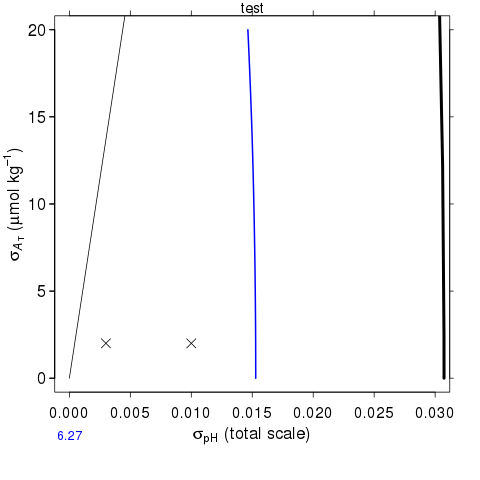

In [207]:
%%R

#   options(repr.plot.width=7.0, repr.plot.height=7)
  options(repr.plot.width=10.0, repr.plot.height=7)


#     dim(rCO3) <- c(length(DIC_e), length(ALK_e))
#     dim(rCO3) <- c(length(var2_e), length(var1_e))  #my one

    dim(rCO3) <- c(length(pCO2_e), length(pH_e))  #edited to match mega
#     dim(rCO3_pHAt_socn) <- c(length(pCO2_e), length(pH_e))  ##FROM MEGA NOTEBOOK

    

#   pdf(file="Fig_AbsErrContours2_trop_socn.pdf")
    par(mfrow=c(1,1), mar=c(4,3.7,1,1.5)+0.1, oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1)

    subtitle <- "test"

#   At-Ct
#   -------------------
#     xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#     ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
      xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
      ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))

    sigcritXa <- sig1_AtCt$CO3  ;  sigcritYa <- sig2_AtCt$CO3  #sig2_ is x axis; sig1_ is y axis
    za <- rCO3
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(4.2, seq(4,7,by=1))

    plterrcontour (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
#                    sig1hp_AtCt$CO3, sig2hp_AtCt$CO3,
                   NULL, NULL,
#                    zenon(sigm2_AtCt$CO3), zenon(sigm1_AtCt$CO3),
                   zenon(sigm1_AtCt$CO3), zenon(sigm2_AtCt$CO3),
                   var1_e_soa2, var2_e_soa2,
                   x, y, za, levels1,
                   'flattest')



***Figure:*** Percent relative uncertainty in computed $[\text{CO}_3^{2-}]$ from the $A_\text{T}-C_\text{T}$ input pair as a function of uncertainties in each member of that input pair. Each of those members is indicated by the x- and y-axis labels. Propagated relative error (in percent) is shown for the Southern Ocean (blue solid lines). Sublots without pH as an input member also include the Constants-Pair curve (thick black line), where the total propagated error from the constants is equal to that from the input pair. The balanced-pair line (thin black line) indicates where each member of the input pair contributes equally to total propagated error. 